In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from torchsummary import summary

import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file = "/content/drive/MyDrive/swan_detection/swan_detection.zip"
z = zipfile.ZipFile(zip_file, "r")
z.extractall()

In [ ]:
os.listdir()

['.config', 'drive', 'classification_images', 'sample_data']

# Data preprocessing
<ol>
  <li> Remove bad images (n_channels != 3) </li>
  <li> Save correct path </li>
</ol>

In [ ]:
mask_path = "/content/classification_images/masks"
image_path = "/content/classification_images/images"
os.listdir(mask_path)

['klikun', 'malyi', 'shipun']

In [ ]:
malyi_masks = os.listdir(f"{mask_path}/malyi")
shipun_masks = os.listdir(f"{mask_path}/shipun")
klikun_masks = os.listdir(f"{mask_path}/klikun")

In [ ]:
malyi_images = os.listdir(f"{image_path}/malyi")
shipun_images = os.listdir(f"{image_path}/shipun")
klikun_images = os.listdir(f"{image_path}/klikun")

In [ ]:
klikun_images.sort()
shipun_images.sort()
malyi_images.sort()

klikun_masks.sort()
shipun_masks.sort()
malyi_masks.sort()

In [ ]:
klikun_images_path = [f"{image_path}/klikun/{x}" for x in klikun_images]
shipun_images_path = [f"{image_path}/shipun/{x}" for x in shipun_images]
malyi_images_path = [f"{image_path}/malyi/{x}" for x in malyi_images]

klikun_masks_path = [f"{mask_path}/klikun/{x}" for x in klikun_masks]
shipun_masks_path = [f"{mask_path}/shipun/{x}" for x in shipun_masks]
malyi_masks_path = [f"{mask_path}/malyi/{x}" for x in malyi_masks]

In [ ]:
# remove images with number of channels != 3
def clean_images(images_path, masks_path):
  masks_path_clean = []
  images_path_clean = []
  for path_img, path_mask in zip(images_path,masks_path):
    to_tensor = A.Compose([ToTensorV2()])
    image = to_tensor(image = np.array(Image.open(path_img)))
    n_ch = image['image'].shape[0]
    if n_ch==3:
      masks_path_clean.append(path_mask)
      images_path_clean.append(path_img)
    else:
      print(path_img)
  return images_path_clean, masks_path_clean

In [ ]:
klikun_images_clean, klikun_masks_clean = clean_images(klikun_images_path, klikun_masks_path)
shipun_images_clean, shipun_masks_clean = clean_images(shipun_images_path, shipun_masks_path)
malyi_images_clean, malyi_masks_clean = clean_images(malyi_images_path, malyi_masks_path)

/content/classification_images/images/shipun/img_2998.jpg
/content/classification_images/images/malyi/img_48.jpg
/content/classification_images/images/malyi/img_49.jpg
/content/classification_images/images/malyi/img_50.jpg
/content/classification_images/images/malyi/img_51.jpg
/content/classification_images/images/malyi/img_52.jpg
/content/classification_images/images/malyi/img_53.jpg
/content/classification_images/images/malyi/img_54.jpg
/content/classification_images/images/malyi/img_55.jpg
/content/classification_images/images/malyi/img_56.jpg
/content/classification_images/images/malyi/img_57.jpg
/content/classification_images/images/malyi/img_58.jpg
/content/classification_images/images/malyi/img_59.jpg
/content/classification_images/images/malyi/img_60.jpg
/content/classification_images/images/malyi/img_61.jpg
/content/classification_images/images/malyi/img_62.jpg
/content/classification_images/images/malyi/img_63.jpg
/content/classification_images/images/malyi/img_64.jpg
/conten

In [ ]:
print(len(klikun_images_clean)," ", len(klikun_masks_clean))
print(len(shipun_images_clean), " ", len(shipun_masks_clean))
print(len(malyi_images_clean), " ", len(malyi_masks_clean))

3025   3025
3010   3010
2961   2961


Save clean images paths

In [ ]:
klikun_path_df = pd.DataFrame(data = {"images":klikun_images_clean, "masks": klikun_masks_clean})
klikun_path_df.to_csv("klikun_path.csv", index=False)

shipun_path_df = pd.DataFrame(data = {"images": shipun_images_clean, "masks":shipun_masks_clean})
shipun_path_df.to_csv("shipun_path.csv",index=False)

malyi_path_df = pd.DataFrame(data = {"images" : malyi_images_clean, "masks": malyi_masks_clean})
malyi_path_df.to_csv("malyi_path.csv",index=False)

# Data Load and splitting

In [ ]:
malyi_path_df

,images,masks
0,/content/files/images/malyi/00120000501.jpg,/content/files/masks/malyi/00120000501.png
1,/content/files/images/malyi/00120047902.jpg,/content/files/masks/malyi/00120047902.png
2,/content/files/images/malyi/00120047904.jpg,/content/files/masks/malyi/00120047904.png
3,/content/files/images/malyi/00320099101.jpg,/content/files/masks/malyi/00320099101.png
4,/content/files/images/malyi/005-5-1024x683.jpg,/content/files/masks/malyi/005-5-1024x683.png
...,...,...
2956,/content/files/images/malyi/original (7).jpg,/content/files/masks/malyi/original (7).png
2957,/content/files/images/malyi/original (8).jpg,/content/files/masks/malyi/original (8).png
2958,/content/files/images/malyi/original (9).jpg,/content/files/masks/malyi/original (9).png
2959,/content/files/images/malyi/original.jpg,/content/files/masks/malyi/original.png


In [ ]:
images_fullpath = pd.concat([klikun_path_df["images"],shipun_path_df["images"],malyi_path_df["images"]],axis=0,ignore_index=True)
masks_fullpath = pd.concat([klikun_path_df["masks"],shipun_path_df["masks"],malyi_path_df["masks"]],axis=0,ignore_index=True)

In [ ]:
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(np.arange(len(images_fullpath)), test_size=0.2) # 20% test

idx_train, idx_val = train_test_split(idx_train, test_size=0.125) # 70% train; 10% valid

In [ ]:
len(idx_train) + len(idx_val) + len(idx_test)

8996

In [ ]:
images_train = images_fullpath[idx_train].to_numpy()
masks_train = masks_fullpath[idx_train].to_numpy()

images_val = images_fullpath[idx_val].to_numpy()
masks_val = masks_fullpath[idx_val].to_numpy()

images_test = images_fullpath[idx_test].to_numpy()
masks_test = masks_fullpath[idx_test].to_numpy()

# Make Datasets

In [ ]:
class CustomImageDataset(torch.utils.data.Dataset):
  def __init__(self, images_path, masks_path, transformer=None):
    self.images_path = images_path
    self.masks_path = masks_path
    self.transformer = transformer

  def __len__(self):
    return len(self.images_path)

  def __getitem__(self,idx):
      image_filename = self.images_path[idx]
      mask_filename = self.masks_path[idx]

      image = np.array(Image.open(image_filename))
      mask = np.array(Image.open(mask_filename))

      if self.transformer:
        transformed = self.transformer(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        mask = (mask != 0).to(torch.float64)
      return image, mask

In [ ]:
train_transform = A.Compose([
                              A.Resize(272, 272, always_apply=True),
                              A.RandomFog(p=0.2),
                              A.RandomShadow(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),
                              A.HorizontalFlip(p=0.2),
                              A.VerticalFlip(p=0.2),
                              A.Rotate(limit=[-45,45], p=0.2),
                              A.Normalize(),
                              ToTensorV2(),], is_check_shapes=False)
val_transform = A.Compose([A.Resize(272, 272, always_apply=True),
                           A.Normalize(),
                           ToTensorV2(),], is_check_shapes=False)

NameError: ignored

In [ ]:
dataset_train = CustomImageDataset(images_train, masks_train,train_transform)
dataset_val = CustomImageDataset(images_val, masks_val,val_transform)
dataset_test = CustomImageDataset(images_test, masks_test,val_transform)

In [ ]:
len(dataset_train) + len(dataset_val) + len(dataset_test)

8996

In [ ]:
import copy
def plot_image(dataset, idx):
  ds = copy.deepcopy(dataset)
  ds.transformer = A.Compose([x for x in dataset.transformer if not  isinstance(x,(A.Normalize))])
  image, mask = ds[idx]
  trans = transforms.Compose([transforms.ToPILImage()])
  fig, ax = plt.subplots(1,2, figsize=(16,9))
  ax[0].imshow(trans(image))
  ax[1].imshow(trans(mask))
  plt.show()

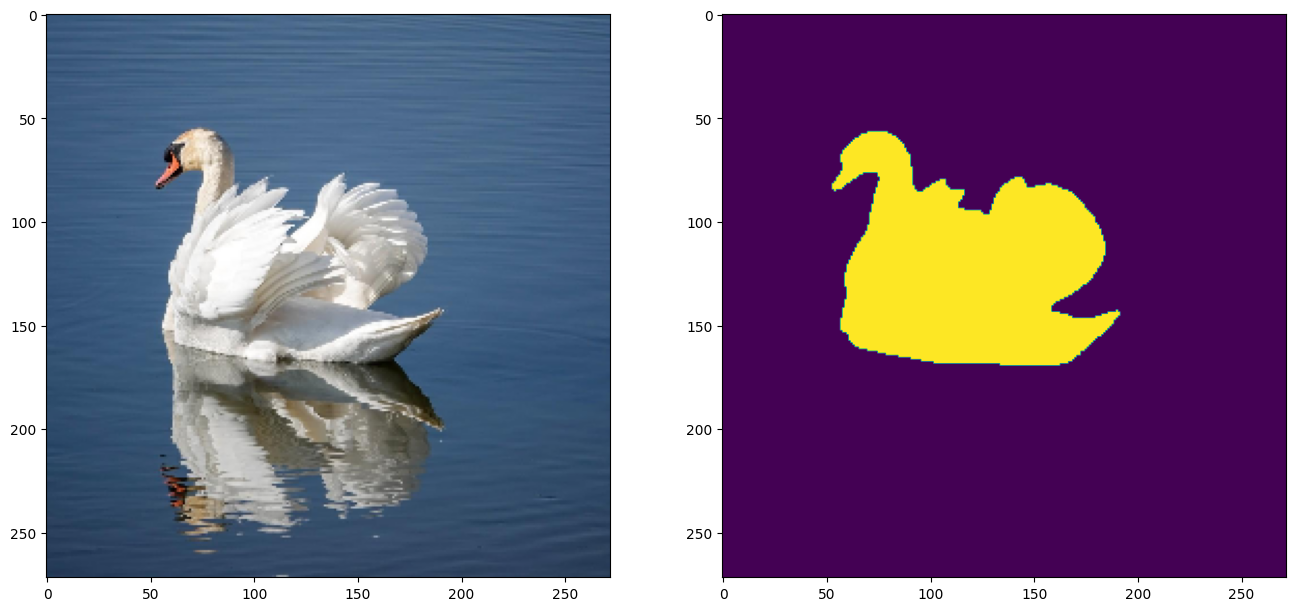

In [ ]:
plot_image(dataset_train, 1000)

# Make DataLoader

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset_train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=16, shuffle=True)

In [ ]:
def plot_batch_image(batch, idx):
  images, masks = batch
  img = images[idx]
  mask = masks[idx]

  trans = transforms.Compose([transforms.ToPILImage()])
  fig, ax = plt.subplots(1,2, figsize=(16,9))
  ax[0].imshow(trans(img))
  ax[1].imshow(trans(mask))
  plt.show()

torch.Size([16, 3, 272, 272])


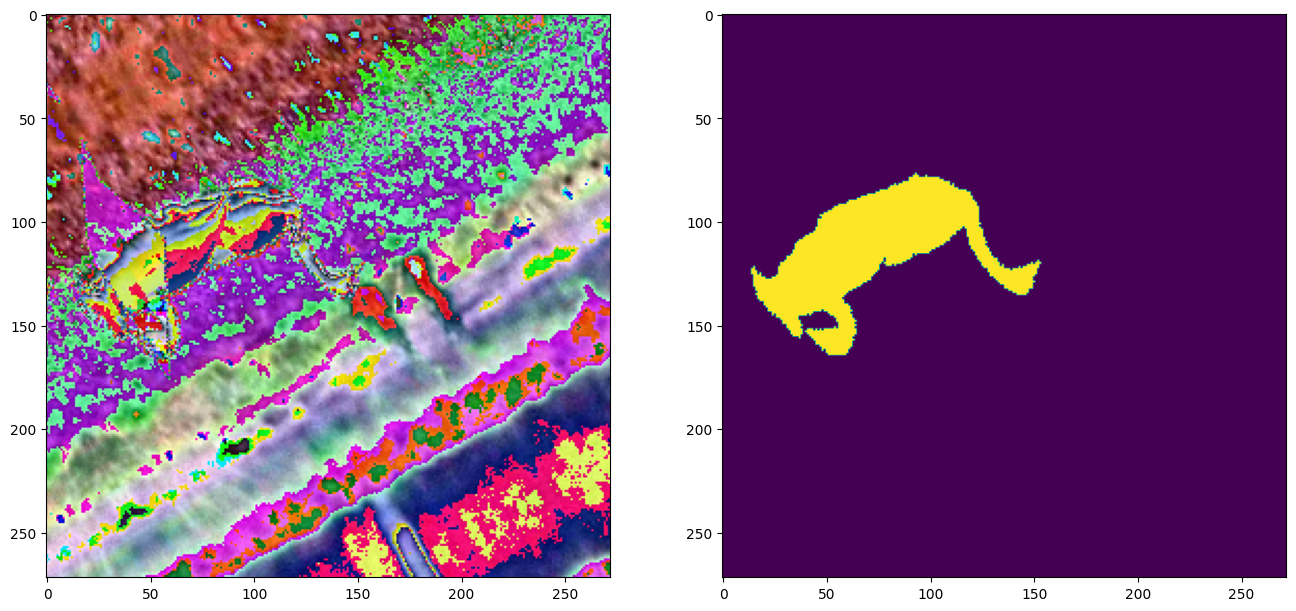

In [ ]:
for batch in train_dataloader:
  i, a = batch
  print(i.shape)
  plot_batch_image(batch, 7)
  break

# U-Net Model

In [ ]:
import torch.nn as nn
from torchvision import models

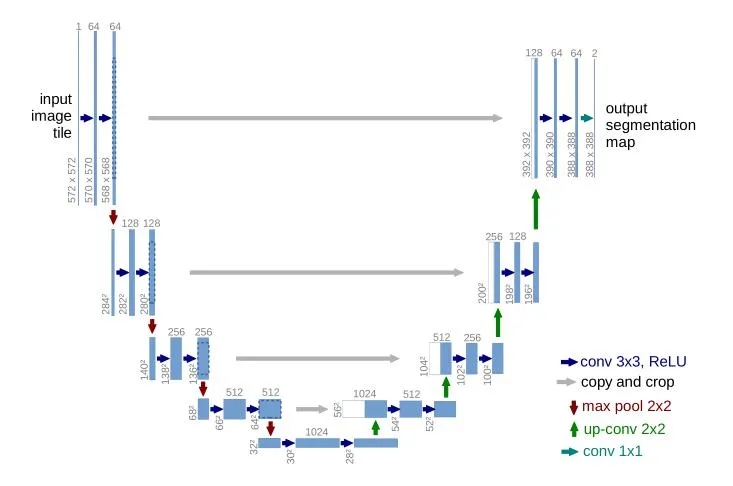

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    # Encoder
    # input 3x268x268
    self.layer1_e1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # 64x266x266
    self.layer1_e2 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # 64x264x264
    self.layer1_epool = nn.MaxPool2d(kernel_size=2, stride=2) # 64x132x132

    # input 64x132x132
    self.layer2_e1 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 128x130x130
    self.layer2_e2 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # 128x128x128
    self.layer2_epool = nn.MaxPool2d(kernel_size=2, stride=2) # 128x64x64

    # input 128x64x64
    self.layer3_e1 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 256x62x62
    self.layer3_e2 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # 256x60x60

    # Decoder
    self.layer2_upconv = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.layer2_d1 = nn.Conv2d(256,128, kernel_size=3, padding=1)
    self.layer2_d2 = nn.Conv2d(128,128, kernel_size=3, padding=1)

    self.layer1_upconv = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.layer1_d1 = nn.Conv2d(128,64, kernel_size=3, padding=1)
    self.layer1_d2 = nn.Conv2d(64,64, kernel_size=3, padding=1)

    self.output = nn.Conv2d(64, 1, kernel_size=1)

    self.relu = nn.ReLU(inplace=True)
  def forward(self,img):
    # Encoder
    img_layer1_e1 = self.relu(self.layer1_e1(img))
    img_layer1_e2 = self.relu(self.layer1_e2(img_layer1_e1))
    img_layer1_epool = self.layer1_epool(img_layer1_e2)

    img_layer2_e1 = self.relu(self.layer2_e1(img_layer1_epool))
    img_layer2_e2 = self.relu(self.layer2_e2(img_layer2_e1))
    img_layer2_epool = self.layer2_epool(img_layer2_e2)

    img_layer3_e1 = self.relu(self.layer3_e1(img_layer2_epool))
    img_layer3_e2 = self.relu(self.layer3_e2(img_layer3_e1))

    # Decoder
    img_layer2_upconv = self.relu(self.layer2_upconv(img_layer3_e2))
    img_layer2_transition = torch.cat([img_layer2_e2,img_layer2_upconv], dim=1)
    img_layer2_d1 = self.relu(self.layer2_d1(img_layer2_transition))
    img_layer2_d2 = self.relu(self.layer2_d2(img_layer2_d1))

    img_layer1_upconv = self.relu(self.layer1_upconv(img_layer2_e2))
    img_layer1_transition = torch.cat([img_layer1_e2,img_layer1_upconv], dim=1)
    img_layer1_d1 = self.relu(self.layer1_d1(img_layer1_transition))
    img_layer1_d2 = self.relu(self.layer1_d2(img_layer1_d1))

    out = self.output(img_layer1_d2)
    return out

In [ ]:
model = UNet()
model = model.to("cuda")
summary(model, (3, 272, 272))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 272, 272]           1,792
              ReLU-2         [-1, 64, 272, 272]               0
            Conv2d-3         [-1, 64, 272, 272]          36,928
              ReLU-4         [-1, 64, 272, 272]               0
         MaxPool2d-5         [-1, 64, 136, 136]               0
            Conv2d-6        [-1, 128, 136, 136]          73,856
              ReLU-7        [-1, 128, 136, 136]               0
            Conv2d-8        [-1, 128, 136, 136]         147,584
              ReLU-9        [-1, 128, 136, 136]               0
        MaxPool2d-10          [-1, 128, 68, 68]               0
           Conv2d-11          [-1, 256, 68, 68]         295,168
             ReLU-12          [-1, 256, 68, 68]               0
           Conv2d-13          [-1, 256, 68, 68]         590,080
             ReLU-14          [-1, 256,

In [ ]:
from tqdm.notebook import tqdm, trange
def train_epoch(train_loader, model, optimizer, criterion, device):
  model.train()
  pbar = tqdm(enumerate(train_loader), total=len(train_loader))
  loss_list = []
  for i, (images, masks) in pbar:
    images = images.to(device)
    masks = masks.to(device)
    optimizer.zero_grad()
    outputs = torch.sigmoid(model(images))
    masks = torch.unsqueeze(masks,1)
    loss=criterion(outputs.to(torch.float64), masks.to(torch.float64))
    loss.backward()
    optimizer.step()
    pbar.set_description(
        f"Loss: {round(loss.item(),4)}"
     )
    loss_list.append(loss.item())
  return np.mean(loss_list)

def IOU(label, pred):
  flat_label = label.flatten().astype(bool)
  flat_pred = pred.flatten().astype(bool)
  inter = (flat_label & flat_pred)
  union = ((flat_label + flat_pred) > 0)
  return np.sum(inter)/np.sum(union)

def valid(val_loader, model, criterion, device):
  model.eval()
  acc_list = []
  loss_list = []
  iou_list = []
  pbar = tqdm(enumerate(val_loader), total=len(val_loader))
  for i, (images, masks) in pbar:
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    masks = torch.unsqueeze(masks,1)
    loss=criterion(outputs.to(torch.float64), masks.to(torch.float64))

    pred_labels = (outputs > 1/2).float()

    acc = (pred_labels == masks).float().mean().cpu()

    iou = IOU(masks.cpu().numpy(),pred_labels.cpu().numpy())
    pbar.set_description(
        f"Loss: {round(loss.item(),4)}",
        f"Accuracy: {round(acc.item()*100,4)}%"
    )
    acc_list.append(acc)
    loss_list.append(loss.item())
    iou_list.append(iou)
  return (np.mean(loss_list), np.mean(acc_list), np.mean(iou_list))

In [ ]:
def plot_loss(train_loss_list, val_loss_list):
  fig, ax = plt.subplots(1,2, figsize=(16,5))
  ax[0].plot(np.arange(1,len(train_loss_list)+1),train_loss_list, linestyle="--", c="grey")
  ax[0].scatter(np.arange(1,len(train_loss_list)+1),train_loss_list, c="red")
  ax[0].set_xlabel("epoch")
  ax[0].set_title("Train loss")
  ax[0].set_ylabel("Loss")
  ax[0].set_ylim([0,0.4])
  ax[0].grid()

  ax[1].plot(np.arange(1,len(val_loss_list)+1),val_loss_list, linestyle="--", c="black")
  ax[1].scatter(np.arange(1,len(val_loss_list)+1),val_loss_list, c="red")
  ax[1].set_xlabel("valid epoch (each 2 train epoch)")
  ax[1].set_title("Valid loss")
  ax[1].set_ylabel("Loss")
  ax[1].set_ylim([0,0.3])
  ax[1].grid()

  plt.show()

def plot_metrics(val_acc_list, val_iou_list):
  fig, ax = plt.subplots(1,2, figsize=(16,5))
  ax[0].plot(np.arange(1,len(val_acc_list)+1),val_acc_list,c="gray", linestyle="--")
  ax[0].scatter(np.arange(1,len(val_acc_list)+1),val_acc_list, c="red")
  ax[0].set_xlabel("valid epoch (each 2 train epoch)")
  ax[0].set_ylabel("Accuracy")
  ax[0].set_title("Valid Accuracy")
  ax[0].set_ylim([0.85,1])
  ax[0].grid()
  #ax[0].set_xticklabels(np.arange(1,len(val_acc_list)+1))

  ax[1].plot(np.arange(1,len(val_iou_list)+1),val_iou_list, c="black", linestyle="--")
  ax[1].scatter(np.arange(1,len(val_iou_list)+1),val_iou_list, c="red")
  ax[1].set_xlabel("valid epoch (each 2 train epoch)")
  ax[1].set_ylabel("IOU")
  ax[1].set_title("Valid IOU")
  ax[1].set_ylim([0.4,0.8])
  #ax[1].set_xticklabels(np.arange(1,len(val_iou_list)+1))
  ax[1].grid()

  plt.show()

# Unet model training

In [ ]:
device = "cuda"
model = UNet().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loss_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []

In [ ]:
n_epoch = 2
device = "cuda"
for epoch in range(n_epoch):
  train_loss = train_epoch(train_dataloader,model, optimizer,criterion, device)
  train_loss_list.append(train_loss)

  0%|          | 0/394 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print(np.round(train_loss_list[-5:-1],4))

In [ ]:
val_loss, val_acc, val_iou = valid(val_dataloader, model, criterion, device)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)
val_iou_list.append(val_iou)

In [ ]:
print(np.round(val_loss_list[-5:-1],4))

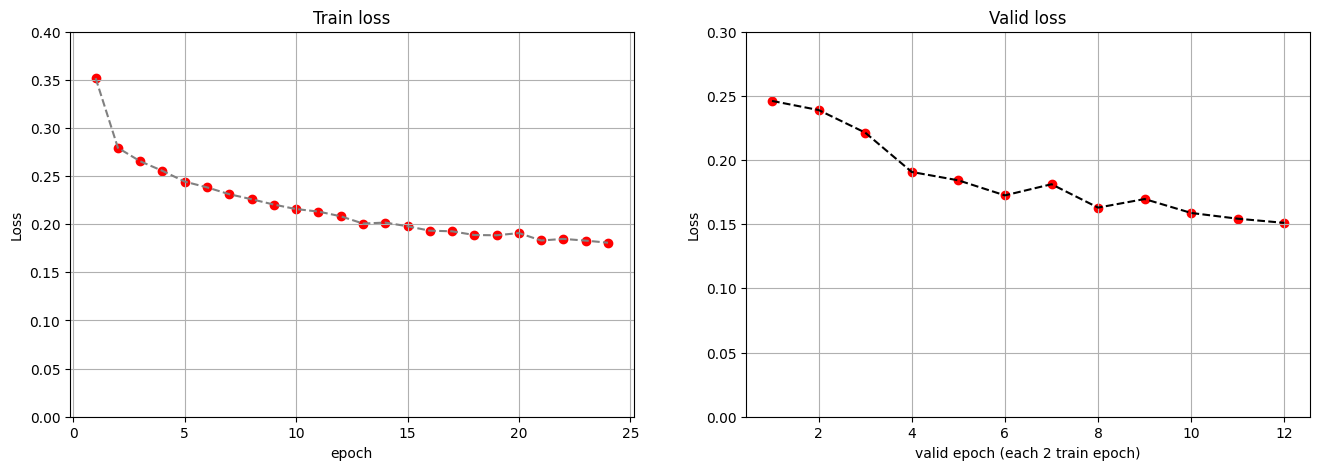

In [ ]:
plot_loss(train_loss_list, val_loss_list)

In [ ]:
plot_metrics(val_acc_list, val_iou_list)

NameError: ignored

# Test

In [ ]:
def test_model(test_dataloader, model, criterion, device):
  _, test_acc, test_iou = valid(test_dataloader, model, criterion, device)
  print("Test acc:", test_acc)
  print("Test IOU: ", test_iou)

In [ ]:
# epoch 24
test_model(test_dataloader, model, criterion, device)

Test acc: 0.94517404
Test IOU:  0.6733120323201024


# Save model

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/swan_detection/unet_model.pth") # epoch 24

# Load model

In [ ]:
unet_model = UNet()
unet_model.load_state_dict(torch.load('/content/drive/MyDrive/swan_detection/unet_model.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
image = np.array(Image.open("/content/files/images/malyi/img_1.jpg")) # initial image
x = val_transform(image = image)
x["image"].unsqueeze_(0)

output = unet_model.forward(x["image"])

In [ ]:
output.shape

torch.Size([1, 1, 272, 272])

In [ ]:
output_mask = torch.sigmoid(output)
output_mask = (output_mask > 1/2).to(torch.float32)

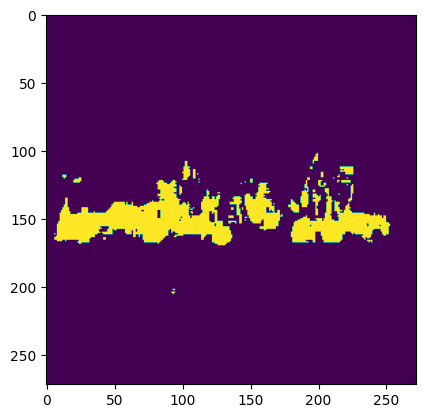

In [ ]:
plt.imshow(torch.squeeze(output_mask))

In [ ]:
trans = A.Compose([A.Resize(272, 272, always_apply=True),ToTensorV2()])
input_img = trans(image = image)["image"]

In [ ]:
input_img.shape

torch.Size([3, 272, 272])

In [ ]:
image_after_unet = output_mask*input_img

In [ ]:
trans_to_img = transforms.Compose([transforms.Resize((image.shape[0], image.shape[1]),interpolation=Image.NEAREST), transforms.ToPILImage()])
image_after_unet = trans_to_img(torch.squeeze(image_after_unet))

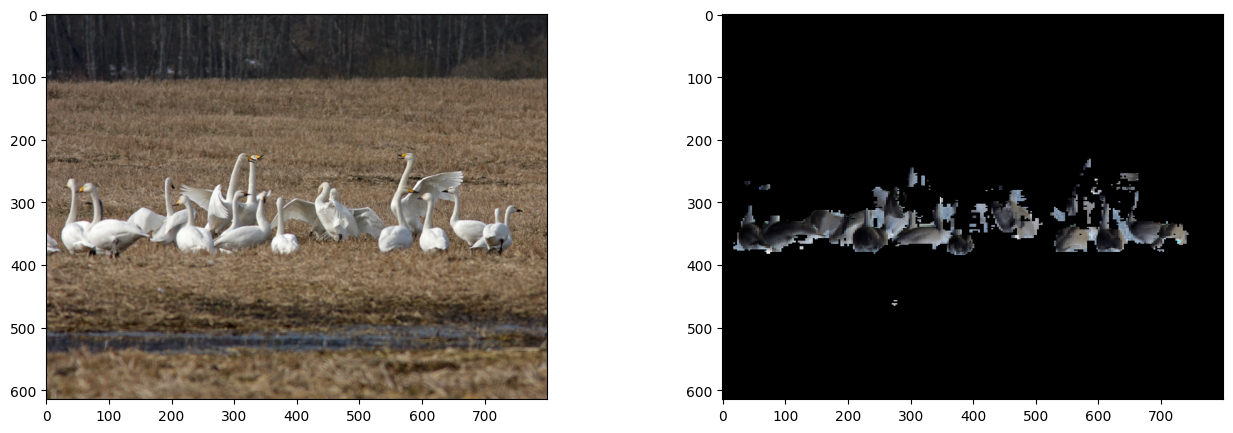

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
ax[0].imshow(image)
ax[1].imshow(image_after_unet)
plt.show()

# Additional training

In [ ]:
device="cuda"
unet_model = unet_model.to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4)

train_loss_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []

In [ ]:
n_epoch = 2
for epoch in range(n_epoch):
  train_loss = train_epoch(train_dataloader,unet_model, optimizer,criterion, device)
  train_loss_list.append(train_loss)

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

In [ ]:
val_loss, val_acc, val_iou = valid(val_dataloader, unet_model, criterion, device)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)
val_iou_list.append(val_iou)

  0%|          | 0/57 [00:00<?, ?it/s]

In [ ]:
print(train_loss_list)
print(val_loss_list)

[0.18010848647333222, 0.17889486879066172, 0.179509355333869, 0.17514146681477483, 0.17414180841511323, 0.17489692659861944, 0.1741712915498948, 0.17162541630719988]
[0.14093968953180044, 0.1461366965341485, 0.13889436885593107, 0.14668417237363118]


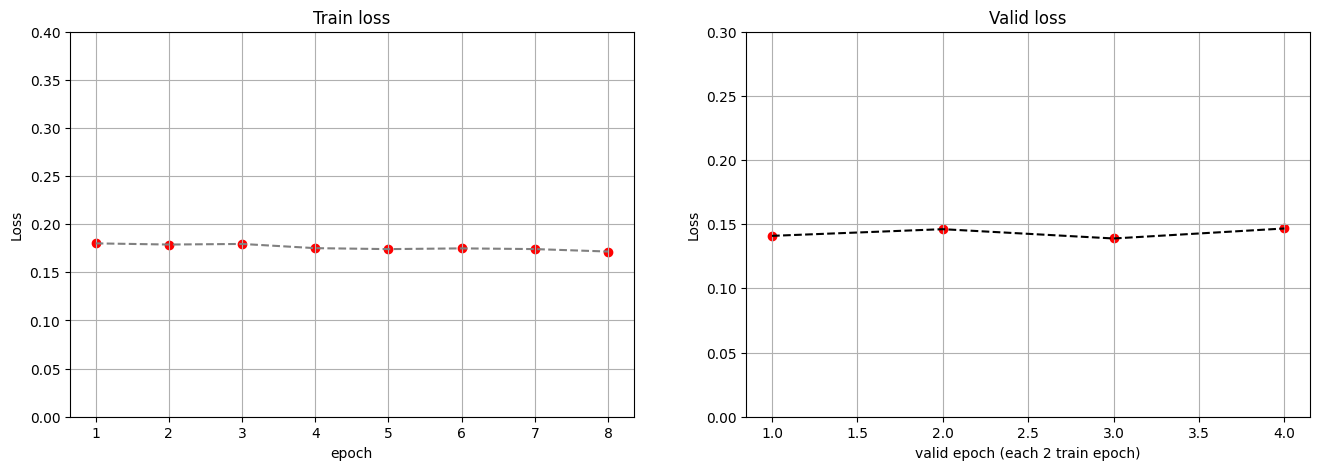

In [ ]:
plot_loss(train_loss_list, val_loss_list)

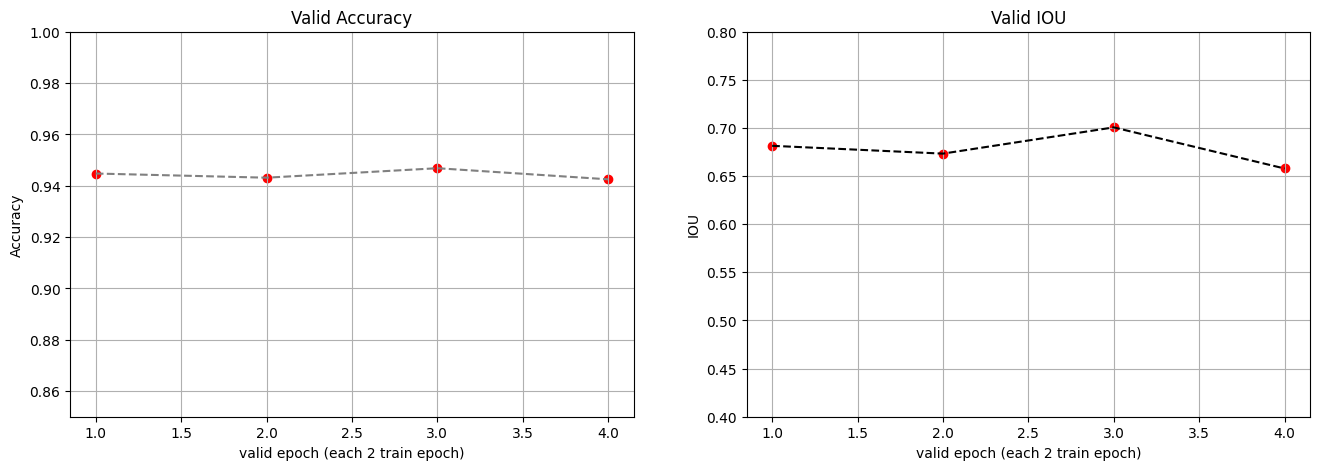

In [ ]:
plot_metrics(val_acc_list, val_iou_list)

In [ ]:
torch.save(unet_model.state_dict(), "/content/drive/MyDrive/swan_detection/unet_model_update.pth") # 30 epoch

In [ ]:
test_model(test_dataloader, unet_model, criterion, device)

  0%|          | 0/113 [00:00<?, ?it/s]

Test acc: 0.947543
Test IOU:  0.69103794091009


<h3> Take 30 epoch!! </h3>

# Save Images after UNet

In [ ]:
! mkdir classification_images
! mkdir /classification_iamges/klikun
! mkdir /classification_iamges/malyi
! mkdir /classification_iamges/shipun

In [ ]:
def make_classification_images(images_path, unet_model):
  for path in images_path:
    image = np.array(Image.open(path)) # initial image
    x = val_transform(image = image)
    img = x["image"].unsqueeze_(0)
    img = img.to(device)
    output = unet_model.forward(img)

    output_mask = torch.sigmoid(output)
    output_mask = (output_mask > 1/2).to(torch.float32)

    trans = A.Compose([A.Resize(272, 272, always_apply=True),ToTensorV2()])
    input_img = trans(image = image)["image"].to(device)

    image_after_unet = output_mask*input_img

    trans_to_img = transforms.Compose([transforms.ToPILImage()])

    image_after_unet = trans_to_img(torch.squeeze(image_after_unet))

    a = path.split("/")
    path_out = "/content/classification_images/" + "/".join(a[-2:])

    image_after_unet.save(path_out)

In [ ]:
make_classification_images(klikun_images_clean, unet_model)

In [ ]:
make_classification_images(malyi_images_clean, unet_model)

In [ ]:
make_classification_images(shipun_images_clean, unet_model)

In [ ]:
! zip classification_images.zip -r classification_images

In [ ]:
! cp classification_images.zip /content/drive/MyDrive/